# BCycle all-data Models EDA

This notebook uses the cleaned data for all trips from the opening of BCycle in 2013 through to the end of 2016. The data provide from BCycle is split into two normalized tables:

## `all_trips_clean.csv`

This is the time-varying trips table, and has the following columns:

* `datetime`: Time the trip began in YYYY-MM-DD HH:MM:SS format. The resolution is 1 minute, i.e. SS is always 00.
* `membership`: Categorical column with memebrship type.
* `bike_id`: Integer ID of the bike used for a trip
* `checkout_id`: ID of the station where the bike was checked out (links to stations table).
* `checkin_id`: ID of the station where the bike was checked in (links to stations table).
* `duration`: The length of the trip in minutes


## `all_stations_clean.csv`

This contains the static station information for all 

* `address`: Station address
* `lat`: Station latitude
* `lon`: Station longitude
* `name`: Station Name
* `station_id`: Station unique identifier (ID), used to link to trips table

There are lots of plots with this new larger dataset.

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

In [2]:
 # todo ! Moved most to all_utils.py

# Load station and trip data

The `notebooks/bcycle_all_data_eda` notebook cleans up the raw CSV file from BCycle, and splits it into a stations and trips dataframe. Because of this, the clean CSV files read in below shouldn't need too much processing.

In [3]:
from bcycle_lib.all_utils import load_bcycle_data

print('Loading stations and trips....', end='')
stations_df, trips_df = load_bcycle_data('../input', 'all_stations_clean.csv', 'all_trips_clean.csv', verbose=False)
print('done!')
print('Bike trips loaded from {} to {}'.format(trips_df.index[0], trips_df.index[-1]))

stations_df.info()


Loading stations and trips....done!
Bike trips loaded from 2013-12-21 09:09:00 to 2016-12-31 23:43:02
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
address       67 non-null object
lat           67 non-null float32
lon           67 non-null float32
name          67 non-null object
station_id    67 non-null uint8
dtypes: float32(2), object(2), uint8(1)
memory usage: 1.7+ KB


# Weekly bike trips in the whole dataset

Let's see how the weekly bike trips vary during the entire dataset by plotting them on a line graph.

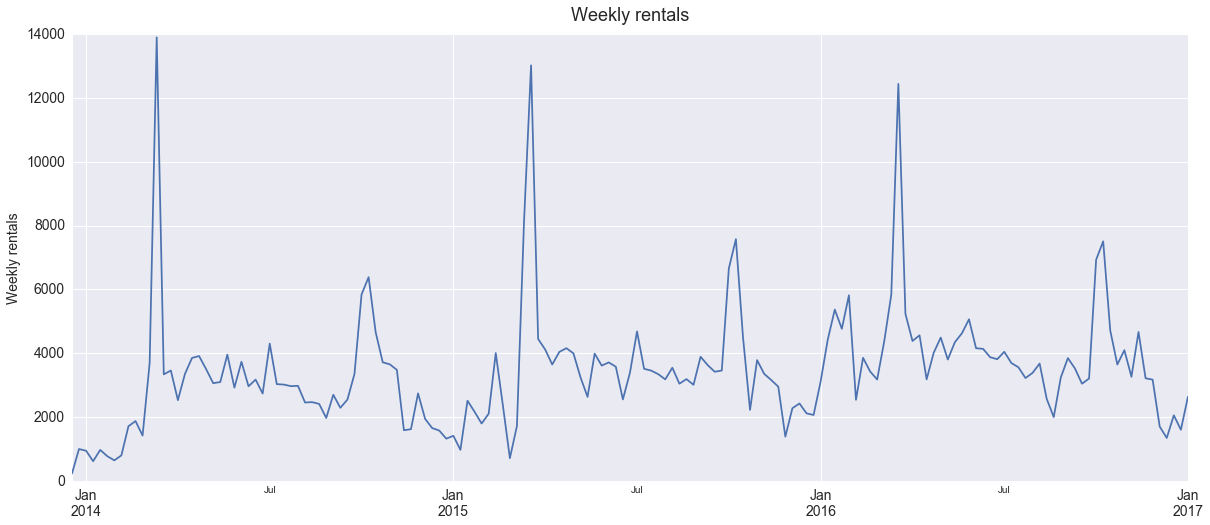

In [4]:
from bcycle_lib.all_utils import plot_lines

# trips_df.resample('W').size().head()
plot_lines(trips_df.resample('W').size(), plt.subplots(1,1, figsize=(20,8)), 
           title='Weekly rentals', xlabel='', ylabel='Weekly rentals')

The rentals show that over the period of 3 years, the amount of rentals is increasing slightly, with 2014 rentals averaging around 3000 per week, 2015 is just under 4000, and 2016 is over 4000. There are also monthly variations, presumably due to the weather.

There are two obvious outliers in the rentals graph which happen every year around the same time. 

* The first is in mid-March, which corresponds to the [SXSW Festival](https://www.sxsw.com). This festival lasts for 7 - 10 days and is split between Interactive, Film, and Music tracks. The Interactive festival is centred on the Austin Convention Center, and during the Music section many venues all around the downtown area and East 6th Street play host to new bands. The peak rentals is ~14000 in both 2014 and 2015, dropping slightly to ~12000 in 2016.


* The second is in early October, when the [ACL Festival](https://www.aclfestival.com) happens. This is a huge music festival split over the first two weekends in October. The festival is held at Zilker Park. This peak is around ~6500 in 2014, increasing to just under 8000 in 2015 and 2016.

# Plotting trips by membership types by year

Let's see how many trips were made by each of the membership types in each year from 2014 to 2016. Note this isn't the amount of people with each membership, as we don't have separate user data to support that. This plot shows how many trips were made using each membership type.

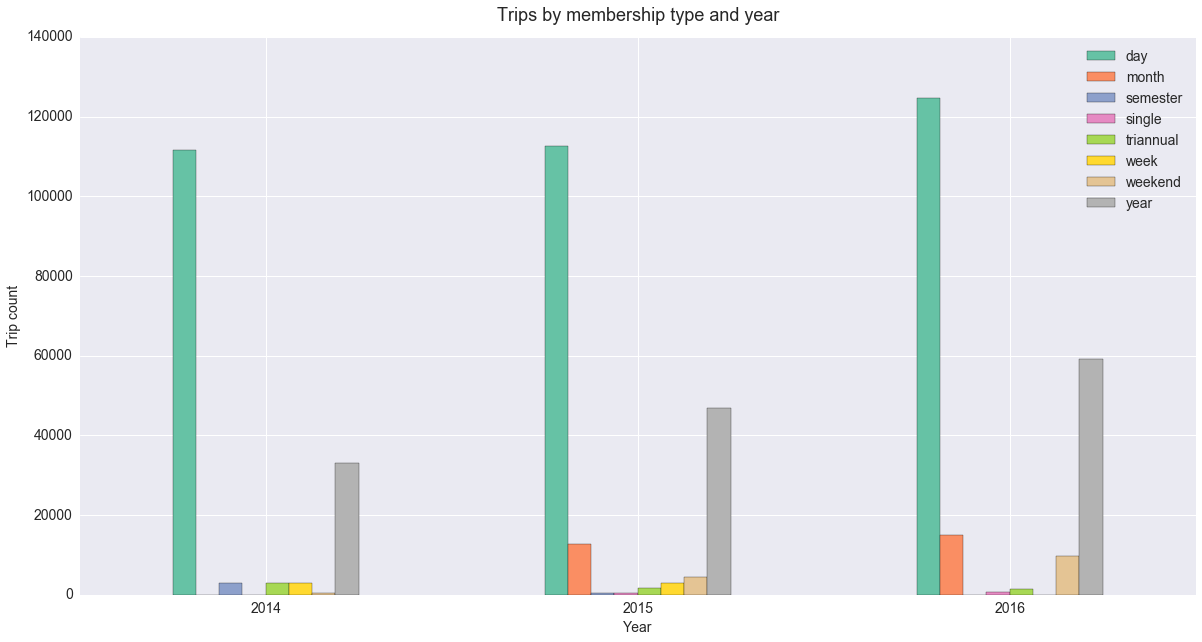

In [5]:
from bcycle_lib.all_utils import plot_bar

plot_df = trips_df.copy()
plot_df['year'] = plot_df.index.year
plot_df = plot_df['2014-01-01':'2016-12-31'].groupby(['year', 'membership']).size().reset_index(name='count')
plot_df = plot_df.pivot_table(index='year', columns='membership', values='count')
plot_df = plot_df.fillna(0)

plot_bar(plot_df, (20,10), title='Trips by membership type and year', xlabel='Year', ylabel='Trip count')

In [6]:
trips_df['membership_string'] = trips_df['membership'].astype(object)
trips_df['membership_string'] = trips_df['membership_string'].replace(['month', 'semester', 'single', 'triannual', 'week', 'weekend'], value='other')
trips_df['membership'] = trips_df['membership_string'].astype('category')
trips_df = trips_df.drop('membership_string', axis=1)


This plot contains quite a bit of information. Remember this is the count of trips by membership type, not the amount of memberships that were sold of each type.

The first observation is that day memberships account for the vast majority of trips in every year, followed by the yearly memberships at around half the trip count, and then monthly memberships. Trips by other memberships are low compared to these. The trips by weekend members is growing rapidly from a small initial value.

Based on this chart, we can split our membership type data by `day`, `year`, and `other`.

# Trip counts by day-of-the-week and membership type

Is there any relation between the time of trips, the day-of-the-week, and the membership type?


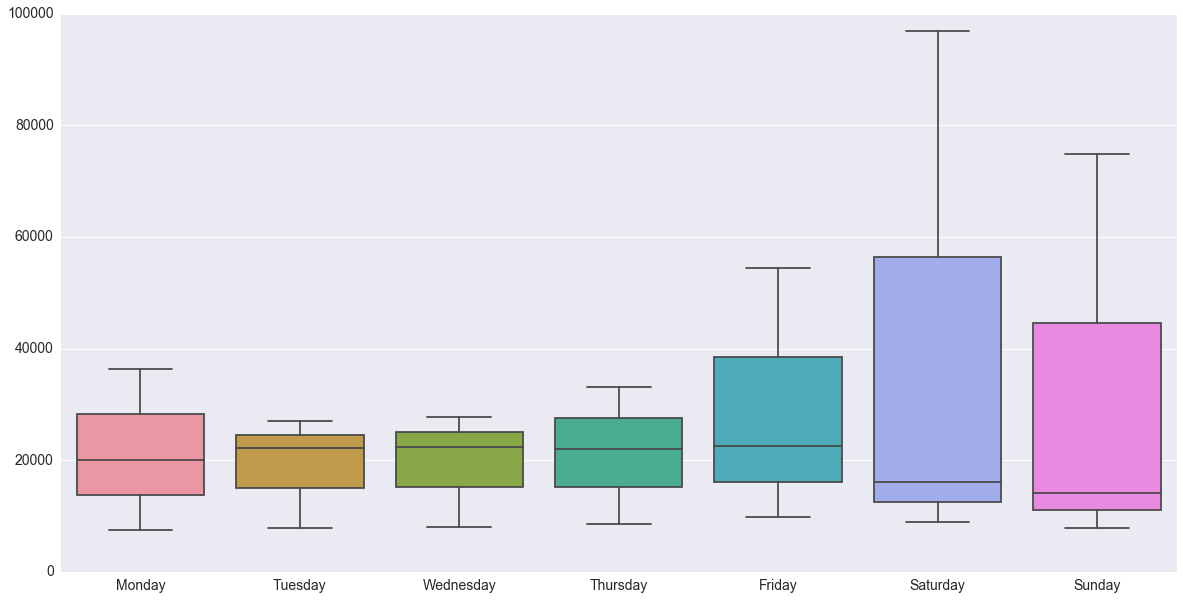

In [7]:
from bcycle_lib.all_utils import plot_boxplot

plot_df = trips_df.copy()
plot_df['weekday_name'] = plot_df.index.weekday_name
plot_df = plot_df.groupby(['membership', 'weekday_name']).size().reset_index(name='count')
plot_df

day_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot_boxplot(plot_df, order=day_names, x='weekday_name', y='count', figsize=(20,10), title='', xlabel='', ylabel='')
# plot_df[plot_df['membership'] == 'semester'] = 'day'


# fig, ax = plt.subplots(1,1, figsize=(16,10))  
# ax = sns.boxplot(data=boxplot_trips_df, x="weekday_name", y="checkouts", order=day_names)
# ax.set_xlabel('', fontdict={'size' : 14})
# ax.set_ylabel('Daily checkouts', fontdict={'size' : 14})
# ax.set_title('Daily checkouts', fontdict={'size' : 18})
# ax.tick_params(axis='x', labelsize=14)
# ax.tick_params(axis='y', labelsize=14)

# Scatterplot of trip durations split by membership type

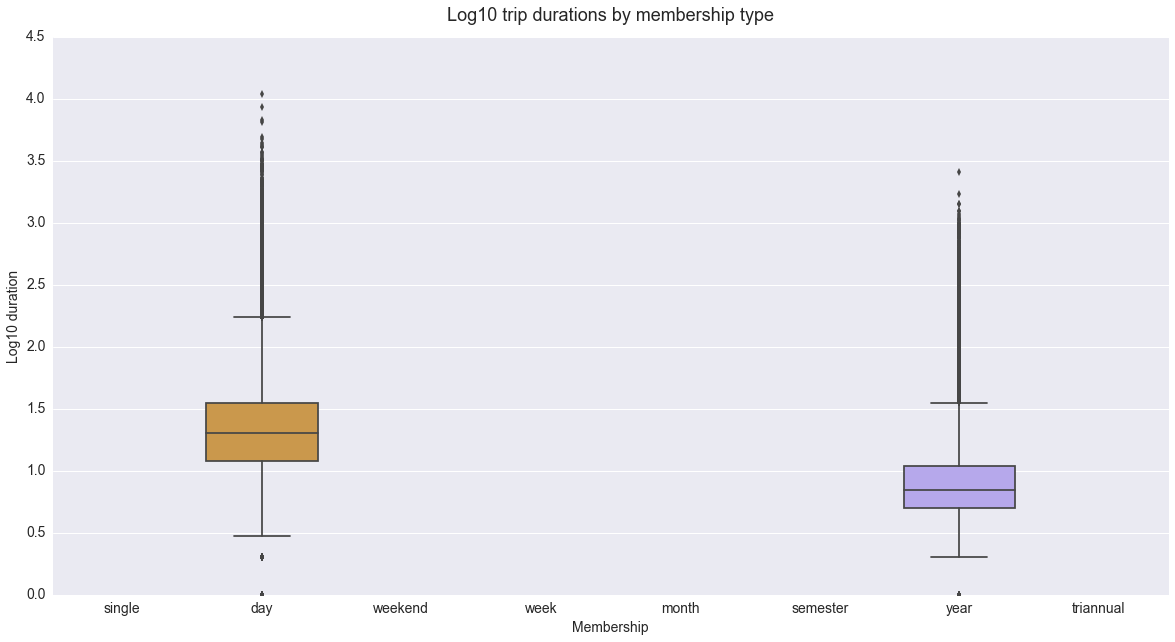

In [8]:
plot_df = trips_df.copy()
plot_df['log10_duration'] = plot_df['duration'].apply(np.log10)
membership_order = ['single', 'day', 'weekend', 'week', 'month', 'semester', 'year', 'triannual']
plot_boxplot(plot_df, order=membership_order, 
             x='membership', y='log10_duration', 
             figsize=(20,10), title='Log10 trip durations by membership type', xlabel='Membership', ylabel='Log10 duration')

# trips_df.plot.scatter(x='membership')

# Trip duration outliers

Let's see how the distribution of trip durations looks. I suspect there will be a lot of low and high outliers !

In [9]:
### Trip duration low outliers

trips_df['duration'].describe()

count    548158.000000
mean         28.195770
std          71.746617
min           0.000000
25%           8.000000
50%          14.000000
75%          26.000000
max       10981.000000
Name: duration, dtype: float64

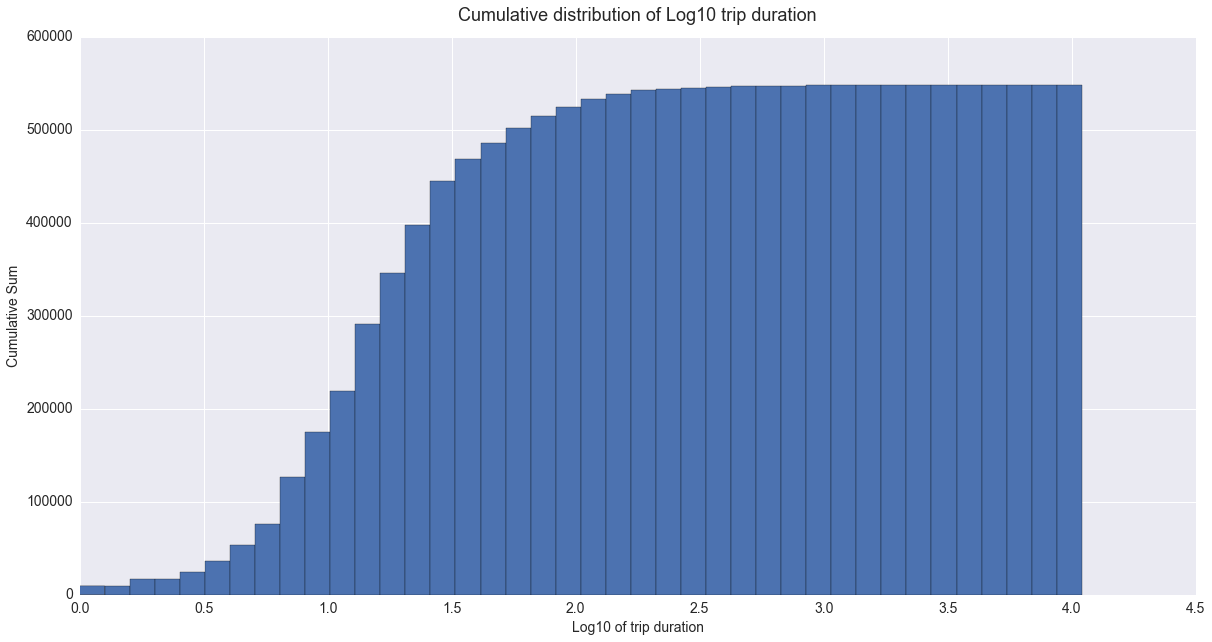

In [10]:
plot_df = trips_df.copy()

trips_df['log10_duration'] = trips_df['duration'].apply(lambda x: np.log10(x+1))


fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax = trips_df['log10_duration'].plot.hist(ax=ax, cumulative=True, bins=40, figsize=(20,10))
ax.set_xlabel('Log10 of trip duration', fontdict={'size' : 14})
ax.set_ylabel('Cumulative Sum', fontdict={'size' : 14})
ax.set_title('Cumulative distribution of Log10 trip duration', fontdict={'size' : 18}) 
ttl = ax.title
ttl.set_position([.5, 1.02])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)   

There are a lot of things to note here. One is the huge range of trip durations, needing a log10 transform to compress their dynamic range into something you can plot. The other is that there are a lot of trips with duration of 0 minutes. For some reason, the duration of trips tends to be larger for shorter-term memberships and vice versa.

In [11]:
LOW_THRESH = 1

low_mask = trips_df['duration'] <= LOW_THRESH
low_trips_df = trips_df[low_mask].groupby('membership').size().reset_index(name='count')
all_trips = trips_df.shape[0]

total_low_trips = low_trips_df['count'].sum()
total_low_trips_pct = (total_low_trips / all_trips) * 100.0

print('Total trips <= {} minute(s) is {} - {:.2f}% of all trips'.format(LOW_THRESH, total_low_trips, total_low_trips_pct))

Total trips <= 1 minute(s) is 17275 - 3.15% of all trips


In [12]:
HIGH_THRESH = 60 * 4

high_mask = trips_df['duration'] >= HIGH_THRESH
high_trips_df = trips_df[high_mask].groupby('membership').size().reset_index(name='count')
all_trips = trips_df.shape[0]

total_high_trips = high_trips_df['count'].sum()
total_high_trips_pct = (total_high_trips / all_trips) * 100.0

print('Total trips >= {} minute(s) is {} - {:.2f}% of all trips'.format(HIGH_THRESH, total_high_trips, total_high_trips_pct))
high_trips_df

Total trips >= 240 minute(s) is 4492 - 0.82% of all trips


,membership,count
0,day,4078
1,other,148
2,year,266


In [13]:
# Use low and high thresholds to drop outlier rows
def threshold_df(df, col, low=None, high=None, verbose=False):
    '''Uses the specified column and low and high values to drop rows
    INPUT: df - DataFrame to filter
           col - Column name in DataFrame to use with thresholds
           low - low threshold (rows less than this value are dropped)
           high - high threshold (rows greater than this value are dropped)
    RETURNS: Dataframe with thresholds applied
    '''
    if low is None and high is None:
        raise ValueError('Need to specify at least one threshold')
    
    n_rows = df.shape[0]
    mask = np.zeros((n_rows), dtype=np.bool)

    if low is not None:
        low_mask = df[col] < low
        low_count = np.sum(low_mask)
        low_pct = (low_count / n_rows) * 100.0
        mask |= low_mask
        if verbose: print('Low threshold {}, dropping {} rows ({:.2f}% of DF)'.format(low, low_count, low_pct))
    
    if high is not None:
        high_mask = df[col] > high
        high_count = np.sum(high_mask)
        high_pct = (high_count / n_rows) * 100.0
        mask |= high_mask
        if verbose: print('High threshold {}, dropping {} rows ({:.2f}% of DF)'.format(high, high_count, high_pct))
    
    masked_df = df[~mask]
    return masked_df

trips_thresh_df = threshold_df(trips_df, 'duration', low=1, high=(60 * 4), verbose=True)

Low threshold 1, dropping 9558 rows (1.74% of DF)
High threshold 240, dropping 4452 rows (0.81% of DF)


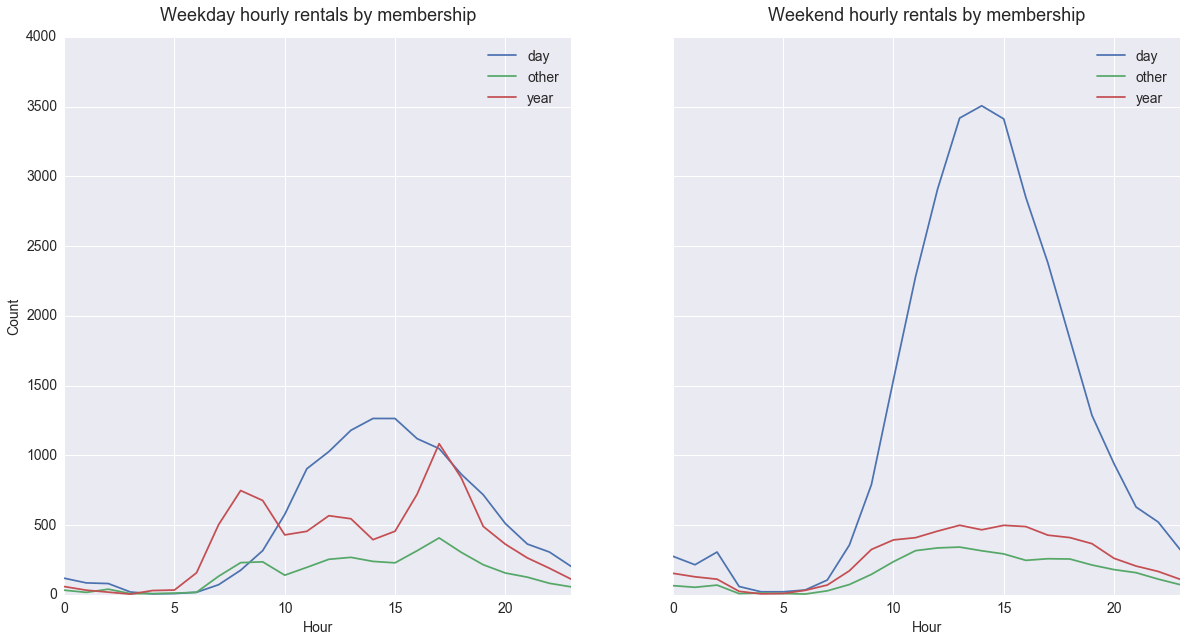

In [90]:
# Plot histograms of trip durations, split by membership


plot_df = trips_thresh_df['2016'].copy()
plot_df['weekday'] = plot_df.index.dayofweek <5
plot_df['hour'] = plot_df.index.hour
plot_df = plot_df.groupby(['membership', 'weekday', 'hour']).size().reset_index(name='count')
plot_df.loc[plot_df['weekday'] == True, 'count'] /= 5.0
plot_df.loc[plot_df['weekday'] == False, 'count'] /= 2.0


# plot_df = plot_df.pivot_table(index='hour', columns='membership')
# plot_df = plot_df.pivot_table(index=plot_df.index, columns='membership', values='duration')
# plot_df = plot_df.resample('1H').size()
# plot_df = plot_df.fillna(0)
# plot_df.plot.line(x='hour', y='0')

weekday_df = plot_df[plot_df['weekday'] == True]
weekend_df = plot_df[plot_df['weekday'] == False]

weekday_df = weekday_df.pivot_table(index='hour', columns='membership', values='count')
weekend_df = weekend_df.pivot_table(index='hour', columns='membership', values='count')


fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
weekday_df.plot.line(ax=ax[0])
weekend_df.plot.line(ax=ax[1])
for axis in ax:
    axis.set_xlabel('Hour', fontdict={'size' : 14})
    axis.set_ylabel('Count', fontdict={'size' : 14})
#     axis.set_title('', fontdict={'size' : 18}) 
    ttl = axis.title
    ttl.set_position([.5, 1.02])
    axis.tick_params(axis='x', labelsize=14)
    axis.tick_params(axis='y', labelsize=14)  
    axis.legend(fontsize = 14)



ax[0].set_title('Weekday hourly rentals by membership', fontdict={'size' : 18})
ax[1].set_title('Weekend hourly rentals by membership', fontdict={'size' : 18})



# Scatterplot of speeds for each trip

Let's see how the speeds vary for each of the trips in the dataframe. We can also use a different colour for membership types to see where these are in the plot

# Out-and-back vs point-to-point trips by membership type

Is there a relationship between out-and-back and point-to-point trips by either membership type, or weekday / weekend?

# Rebalancing bikes

Let's see how many bike trips start at a different station to where they finished. This can only happen if BCycle steps in and shuttles bikes around the system. Let's also plot this by time of day,and day of week. 

# Hourly rentals by day-of-week and weekend for members

Let's use the 2016 trip data, to get the most recent picture.

In [21]:
plot_df = 
# plot_df = trips_thresh_df.resample('1H').size()

plot_df

datetime
2013-12-21 09:00:00      2
2013-12-21 10:00:00      1
2013-12-21 11:00:00      0
2013-12-21 12:00:00      0
2013-12-21 13:00:00      4
2013-12-21 14:00:00     13
2013-12-21 15:00:00     17
2013-12-21 16:00:00     24
2013-12-21 17:00:00     12
2013-12-21 18:00:00      6
2013-12-21 19:00:00      9
2013-12-21 20:00:00      2
2013-12-21 21:00:00      3
2013-12-21 22:00:00      7
2013-12-21 23:00:00      1
2013-12-22 00:00:00      0
2013-12-22 01:00:00      0
2013-12-22 02:00:00      0
2013-12-22 03:00:00      0
2013-12-22 04:00:00      0
2013-12-22 05:00:00      0
2013-12-22 06:00:00      0
2013-12-22 07:00:00      0
2013-12-22 08:00:00      3
2013-12-22 09:00:00      1
2013-12-22 10:00:00      4
2013-12-22 11:00:00      5
2013-12-22 12:00:00     18
2013-12-22 13:00:00     18
2013-12-22 14:00:00     13
                      ... 
2016-12-30 18:00:00     16
2016-12-30 19:00:00      3
2016-12-30 20:00:00      6
2016-12-30 21:00:00      6
2016-12-30 22:00:00      2
2016-12-30 23:00:00

# Trip Duration

Let's see how the distribution of trip duration looks

In [ ]:
from bcycle_lib.all_utils import plot_hist

plot_hist(trips_df['duration'], bins=40, size=(20,10), 
          title='Trip Duration histogram', xlabel='', ylabel='Duration (minutes)')

trips_df['duration'].describe()


That's a very right-skewed distribution ! Let's work out where the threshold is to drop these long trips.

In [ ]:
plot_df = trips_df.copy()
plot_df['log_duration'] = plot_df['duration'] + 1.0
plot_df['log_duration'] = plot_df['duration'].apply(np.log10)

# plot_df = plot_df.groupby('log_duration').size().cumsum()
plot_df['log_duration'].plot.line(figsize=(20,10))

# Weather impact on trips

Let's see how the different weather information affects the amount of trips by hour. We need to read in and merge the daily weather with the hourly trips dataframe.

In [ ]:
from bcycle_lib.all_utils import clean_weather

weather_df = pd.read_csv('../input/all_weather.csv')
weather_df = weather_df.set_index('date')
print(weather_df.describe())
weather_df.head()

In [ ]:
daily_trips_df = trips_df.resample('1D').size().to_frame(name='rentals')
# # Merge the training and validation datasets with the weather dataframe

def merge_daily_weather(df, weather_df):
    '''Merges the dataframes using the date in their indexes
    INPUT: df - Dataframe to be merged with date-based index
           weather_df - Dataframe to be merged with date-based index
    RETURNS: merged dataframe
    '''    

    # Extract the date only from df's index
    df = df.reset_index()
    df['date'] = df['datetime'].dt.date.astype('datetime64')
#     df = df.set_index('datetime')
    
    # Extract the date field to join on
    weather_df = weather_df.reset_index()
    weather_df['date'] = weather_df['date'].astype('datetime64')
    
    # Merge with the weather information using the date
    merged_df = pd.merge(df, weather_df, on='date', how='left')
    merged_df.index = df.index
    merged_df = merged_df.set_index('datetime', drop=True)
    merged_df = merged_df.drop('date', axis=1)
    assert df.shape[0] == merged_df.shape[0], "Error - row mismatch after merge"
    
    return merged_df

GOOD_COLS = ['max_temp', 'min_temp', 'max_gust', 'precipitation', 
        'cloud_pct', 'thunderstorm']


daily_trips_df = merge_daily_weather(daily_trips_df, weather_df[GOOD_COLS])
daily_trips_df.head()

In [ ]:
daily_trips_df.describe()

### Precipitation effects on rentals

Let's plot some scatterplots to see how the weather influences daily rentals in the BCycle network.

In [ ]:
sns.jointplot(x="precipitation", y="rentals", data=daily_trips_df, kind='reg');


In [ ]:
sns.jointplot(x="max_temp", y="rentals", data=daily_trips_df, kind='reg');

In [ ]:
sns.jointplot(x="min_temp", y="rentals", data=daily_trips_df, kind='reg');

In [ ]:
daily_trips_df['diff_temp'] = daily_trips_df['max_temp']  - daily_trips_df['min_temp'] 
sns.jointplot(x="diff_temp", y="rentals", data=daily_trips_df, kind='reg');

In [ ]:
# sns.pairplot(daily_trips_df[['rentals', 'max_temp', 'min_temp', 'max_gust', 'precipitation', 'cloud_pct', 'thunderstorm'
# ]], kind='reg')

In [ ]:
# daily_trips_df['rentals_sqrt'] = daily_trips_df['rentals'].apply(lambda x: np.sqrt(x))

# sns.pairplot(daily_trips_df[['rentals_sqrt', 'max_temp', 'min_temp', 'max_gust', 'precipitation', 'cloud_pct', 'thunderstorm'
# ]], kind='reg')